In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, Math, display

import numpy as np

In [2]:
def bungee_jumper_velocity(m, cd, t, g=9.8):
    return np.sqrt(g * m / cd) * np.tanh(np.sqrt(g*cd/m) * t)

def bungee_jumper_acceleration(m, cd, v, g=9.8):
    return g - (cd * v ** 2 /m)

data = dict(
    m=68.1,
    cd=0.25,
    v0=0,
    dt=2,
    t0=0,
    t_final=20,
)

acceleration = lambda t, y: bungee_jumper_acceleration(m=data['m'], cd=data['cd'], v=y, g=9.8)

# Solve Analytically

$$ \frac{dv}{dt} = g - \frac{C_d v^2}{m} $$
$$ v(t) = \sqrt{\frac{m g}{C_d}} \tanh{(\sqrt{\frac{g C_d}{m}} t)}  $$


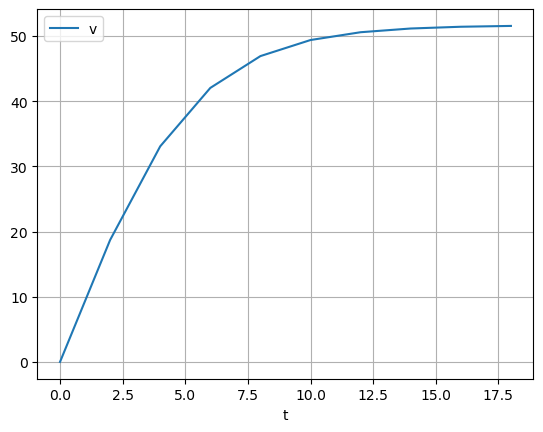

In [3]:
analytical_df = pd.DataFrame(
    data=dict(
        t=np.arange(data['t0'], data['t_final'], data['dt'])
    )
)
analytical_df['v'] = bungee_jumper_velocity(
    m=data['m'], cd=data['cd'], t=analytical_df['t'], g=9.8)

analytical_df.plot(x='t', y='v', linestyle='-')
df_all = analytical_df.copy()
df_all.rename(columns={'v': 'analytical'}, inplace=True)
plt.grid()

In [4]:
def align_solver_data(solver_df, df, solver_name):
    """
    Aligns time points between solver result and the collection dataframe,
    then adds the solver's velocity data to the collection dataframe.

    Parameters:
    -----------
    solver_df : pd.DataFrame
        Result dataframe from the solver with 't' and 'v' columns
    df : pd.DataFrame
        Collection dataframe for velocity values from all solvers
    solver_name : str
        Name of the solver to use as column name

    Returns:
    --------
    pd.DataFrame
        Updated df_all dataframe with new solver data
    """
    # Make sure we're not modifying the original dataframe
    df = df.copy()

    # Extract solver data with renamed column
    solver_data = solver_df[['t', 'v']].copy()
    solver_data = solver_data.rename(columns={'v': solver_name})

    # Merge with existing collection dataframe
    df = pd.merge(
        df,
        solver_data,
        on='t',
        how='outer'
    )

    return df


def calculate_error(df, reference_col='analytical'):
    """
    Calculates error for all solver columns in df compared to the reference column.

    Parameters:
    -----------
    df : pd.DataFrame
        Collection dataframe with velocity values from all solvers
    reference_col : str
        Name of the column to use as reference (typically the analytical solution)

    Returns:
    --------
    pd.DataFrame
        Error dataframe with columns for each solver's error
    """
    # Create a new dataframe with only the time column
    df_err = pd.DataFrame({'t': df['t']})

    # Get all solver columns (excluding time and reference)
    solver_cols = [col for col in df.columns if col != 't' and col != reference_col]

    # Calculate errors for each solver
    for solver in solver_cols:
        df_err[solver] = (df[solver] - df[reference_col]).abs()

    return df_err

# Euler Method

In [5]:
from ODE.RungeKutta.RKEulerMethod import RKEulerMethod

solver_euler = RKEulerMethod(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Euler Method Butcher tableau}'))
display(Math(solver_euler.butcher_tableau))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
df_euler =solver_euler.run()
clear_output()

In [7]:
df_all = align_solver_data(
    solver_name='euler',
    solver_df=df_euler,
    df=df_all
)
df_euler

,v,t,dy_dt
0,0.000000,0,9.800000
1,19.600000,2,9.785316
2,39.170631,4,9.741263
3,58.653157,6,9.667841
4,77.988840,8,9.565051
5,97.118943,10,9.432893
6,115.984728,12,9.271366
7,134.527460,14,9.080470
8,152.688399,16,8.860206
9,170.408811,18,8.610573


# HeunMethod

In [8]:
from ODE.RungeKutta.RKHeunMethod import RKHeunMethod
solver_heun = RKHeunMethod(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Heun Method Butcher tableau}'))
display(Math(solver_heun.butcher_tableau))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
df_heun = solver_heun.run()
clear_output()

In [10]:
df_all = align_solver_data(
    solver_name='heun',
    solver_df=df_heun,
    df=df_all
)
df_heun

,v,t,dy_dt
0,0.000000,0,9.800000
1,19.585316,2,9.785316
2,39.111894,4,9.741263
3,58.520999,6,9.667841
4,77.753891,8,9.565051
5,96.751836,10,9.432893
6,115.456094,12,9.271366
7,133.807930,14,9.080470
8,151.748605,16,8.860206
9,169.219383,18,8.610573


# RungeKutta4

In [11]:
from ODE.RungeKutta.RungeKutta4 import RungeKutta4

solver_rk4 = RungeKutta4(
    derivative_function=acceleration,
    t0=data['t0'],
    t_final=data['t_final'],
    y0=data['v0'],
    h=data['dt'],
    y_label='v'
)
display(Math(r'\text{Runge Kutta 4 Butcher tableau}'))
display(Math(solver_rk4.butcher_tableau))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
df_rk4 = solver_rk4.run()
clear_output()

In [13]:
df_all = align_solver_data(
    solver_name='rk4',
    solver_df=df_rk4,
    df=df_all
)
df_rk4

,v,t,dy_dt
0,0.000000,0,9.800000
1,19.590210,2,9.785316
2,39.121684,4,9.741263
3,58.535683,6,9.667841
4,77.773470,8,9.565051
5,96.776309,10,9.432893
6,115.485463,12,9.271366
7,133.842193,14,9.080470
8,151.787763,16,8.860206
9,169.263436,18,8.610573


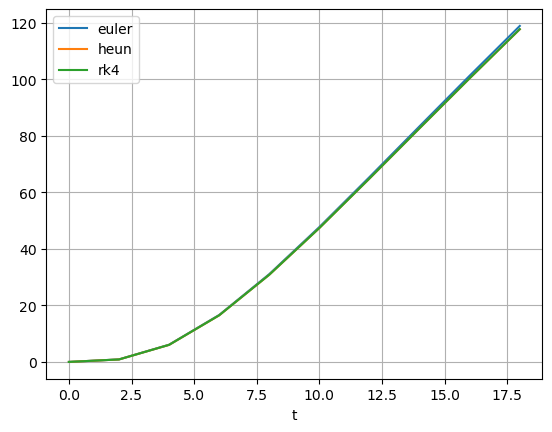

In [14]:
df_error = calculate_error(df_all)
df_error.plot(x='t', y=['euler', 'heun', 'rk4'])
plt.grid()

<Axes: xlabel='t'>

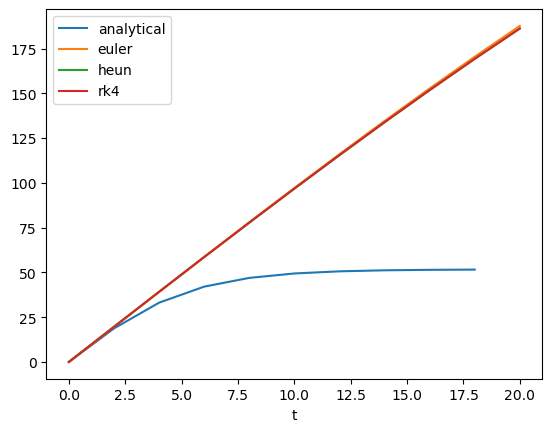

In [15]:
df_all.plot(x='t', y=['analytical','euler', 'heun', 'rk4'])

In [16]:
df_error

,t,euler,heun,rk4
0,0,0.000000,0.000000,0.000000
1,2,0.889045,0.874361,0.879256
2,4,6.087481,6.028744,6.038534
3,6,16.608508,16.476349,16.491033
4,8,31.062281,30.827333,30.846912
5,10,47.727074,47.359966,47.384440
6,12,65.395529,64.866895,64.896263
7,14,83.367772,82.648242,82.682506
8,16,101.259373,100.319578,100.358736
9,18,118.853173,117.663746,117.707799
